In [23]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/G-ZZ/jl_files/zz_samplers.jl")
include("temp.jl")

run_sampler (generic function with 3 methods)

#### Simulate data:

In [6]:
n_groups, group_size = 10, 100
Nobs = group_size*n_groups
dim_cov = 5
dim_total = 1+n_groups+dim_cov

σ02 = 1
my_pr = MM_prior(dim_cov, n_groups, σ02);

In [7]:
pX = 1e0
X = spzeros(dim_total, Nobs)
X[1,:] = 1e-1
X[n_groups+2:end,:] = sprandn(dim_cov, Nobs, pX)
for group in 1:n_groups
    X[group+1,((group-1)*group_size+1):(group*group_size)] = 1.
end
ξ_true = rand(Normal(),dim_total)
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) for j in 1:Nobs])
my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

#### Run sampler:

In [8]:
mb_size = 1
max_attempts = 5*10^6
prob_het = 0.98
adapt_speed = "none"

lambda = 1e0
start = time()
run_sampler(my_model, lambda, max_attempts, mb_size, prob_het, adapt_speed)
print("Time = ", round((time()-start)/60,1), " mins")

Time = 16.0 mins

### Plot ACFs:

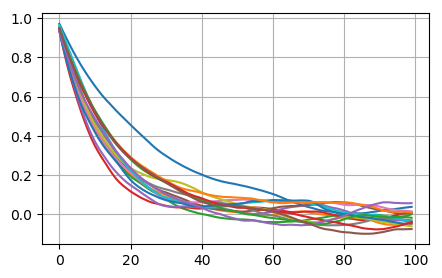

In [19]:
fig = figure("pyplot_barplot",figsize=(5,3))
n_samples = 10^4
maxlag = 100
discard = 0
filename = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
        "-dim_cov:"*string(dim_cov)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
xi_samples_gzz = extract_samples(xt_skel[:,discard+1:end], 
                             bt_skel[:,discard+1:end], 
                            (bt_skel[end]-bt_skel[discard+1])/n_samples,
                            "linear")[:,1:end-1]
iacts_gzz = zeros(size(xi_samples_gzz,1))
for dim in 1:size(xi_samples_gzz,1)
    plot(acf(xi_samples_gzz[dim,:],maxlag))
    grid(true)
    iacts_gzz[dim] = sum(acf(xi_samples_gzz[dim,:], maxlag))
end
xt_skel, bt_skel, xi_samples = [], [], []
gc()

### HMC:

In [10]:
prior = MM_prior(dim_cov, n_groups, 1);
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

In [11]:
ξ0 = randn(dim_total)
stepsize = 1.2e-1
n_leapfrog = 20
T = 5000

xi_samples_hmc, hyper_samples_hmc, acc = GibbsHMC(my_model, ξ0, stepsize, n_leapfrog, T);

10 percent steps in 0.3 min; HMC acceptance = 64 percent 
20 percent steps in 0.5 min; HMC acceptance = 59 percent 
30 percent steps in 0.8 min; HMC acceptance = 59 percent 
40 percent steps in 1.0 min; HMC acceptance = 59 percent 
50 percent steps in 1.3 min; HMC acceptance = 60 percent 
60 percent steps in 1.6 min; HMC acceptance = 60 percent 
70 percent steps in 1.8 min; HMC acceptance = 60 percent 
80 percent steps in 2.1 min; HMC acceptance = 60 percent 
90 percent steps in 2.4 min; HMC acceptance = 60 percent 
100 percent steps in 2.7 min; HMC acceptance = 60 percent 


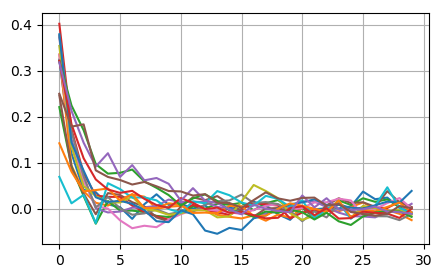

In [20]:
fig = figure("pyplot_barplot",figsize=(5,3))
iacts_hmc = zeros(size(xi_samples_hmc,1))
for i in 1:size(xi_samples_hmc,1) 
    plot(acf(xi_samples_hmc[i,:], 30))
    iacts_hmc[i] = sum(acf(xi_samples_hmc[i,:], 50))
end
grid(true)

In [21]:
hmc_mixing = T/maximum(iacts_hmc)
gzz_mixing = n_samples/maximum(iacts_gzz)
hmc_cost = T*n_leapfrog*Nobs
gzz_cost = max_attempts*mb_size;

In [22]:
(gzz_mixing/gzz_cost)/(hmc_mixing/hmc_cost)

2.52940035552082

### Tune HMC:

In [24]:
prior = MM_prior(dim_cov, n_groups, 1);
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);